In [1]:
# Работа с данными
import pandas as pd
import numpy as np

# Машинное обучение
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
pd.options.mode.chained_assignment = None

# Подготовка признаков
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.feature_selection import VarianceThreshold

# Метрики
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.dummy import DummyClassifier

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 5, 4

# Предупреждения
import warnings
warnings.simplefilter('ignore')

In [2]:
try: data = pd.read_csv('Churn.csv', index_col = 'RowNumber')   
except: data = pd.read_csv('/datasets/Churn.csv', index_col = 'RowNumber')
    
display(data.head(1))
display(data.tail(1))
print()
print(data.info())

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0



<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB
None


## 1 Подготовка данных

In [3]:
# Заполнение пропусков
data['Tenure'] = data['Tenure'].fillna(0)

# Мужчины - 0, Женщины - 1
data['Gender'] = pd.factorize(data['Gender'])[0]

# France - 0, Spain - 1, Germany - 2
data['Geography'] = pd.factorize(data['Geography'])[0]

# float -> int
data['Balance'] = data['Balance'].astype('int')
data['EstimatedSalary'] = data['EstimatedSalary'].astype('int')

# Проверка на дублкаты
data['CustomerId'].duplicated().sum()

0

## 2 Исследование задачи

In [4]:
# Уберем два столбца, которые не влияют на данные
data = data.drop(['CustomerId', 'Surname'], axis=1)

encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

features, target = data_ordinal.drop('Exited', axis=1), data_ordinal['Exited']

# Создание тренировочной и валидационной выборки 70% и 30%
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size=0.7, random_state=20, stratify=target)

# Создание валидационной и тестовой выборки из 30% оставшихся процентов пополам
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, train_size=0.5, random_state=20, stratify=target_valid)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(7000, 10)
(1500, 10)
(1500, 10)


---

DecisionTreeClassifier

In [5]:
#DTC = DecisionTreeClassifier(random_state=20)
#
#parametrs = { 'max_depth': np.arange(1, 20),
#              'max_features': np.arange(1, 10),
#              'min_samples_split': np.arange(2, 10), 
#              'min_samples_leaf': np.arange(2, 10) }
#
#GSCV = GridSearchCV(DTC, parametrs, cv=5, verbose=True)
#GSCV.fit(features_train, target_train)
#
#print('F1:', f1_score(target_valid, GSCV.predict(features_valid)))
#print('AUC_ROC:', roc_auc_score(target_valid, GSCV.predict(features_valid)))

In [6]:
DTC_F = DecisionTreeClassifier(random_state=20, max_depth = 7, max_features = 9, min_samples_split = 2, min_samples_leaf = 7)

DTC_F.fit(features_train, target_train)
predict_DTC_F = DTC_F.predict(features_valid)

print('F1:', f'{f1_score(target_valid, predict_DTC_F):.2f}')
print('AUC_ROC:', f'{roc_auc_score(target_valid, DTC_F.predict_proba(features_valid)[:,1]):.2f}')

F1: 0.52
AUC_ROC: 0.84


Вывод: Модель DecisionTreeClassifier без класификации с дисбалансом, показала F1 = 60%

In [7]:
#target_probabilities = DTC_F.predict_proba(features_valid)[:,1]
#false_positive_rate, true_positive_rate, threshold = roc_curve(target_valid, target_probabilities)
#
#plt.title('Кривая ROC DecisionTreeClassifier')
#plt.plot(false_positive_rate, true_positive_rate)
#plt.plot([0, 1], ls='--')
#plt.plot([0, 0], [1, 0], c='.7')
#plt.plot([1, 1], c='.7')
#plt.ylabel('Доля истинноположительных исходов')
#plt.xlabel('Доля ложноположительных исходов')
#plt.show()

---

RandomForestClassifier

In [8]:
#RFC = RandomForestClassifier(random_state=20)
#
#parametrs = { 'n_estimators': np.arange(10, 30),
#              'max_depth': np.arange(1, 10),
#              'min_samples_leaf': np.arange(1, 5),
#              'min_samples_split': np.arange(1, 5) }
#
#GSCV = GridSearchCV(RFC, parametrs, cv=5, verbose=True)
#GSCV.fit(features_train, target_train)
#
#GSCV.best_params_

In [9]:
RFC_F = RandomForestClassifier(random_state=20, max_depth=9, min_samples_leaf=1, min_samples_split=2, n_estimators=30)

RFC_F.fit(features_train, target_train)
predict_RFC_F = RFC_F.predict(features_valid)

print('F1:', f'{f1_score(target_valid, predict_RFC_F):.2f}')
print('AUC_ROC:', f'{roc_auc_score(target_valid, RFC_F.predict_proba(features_valid)[:,1]):.2f}')

F1: 0.54
AUC_ROC: 0.85


Вывод: Модель RandomForestClassifier без класификации с дисбалансом, показала F1 = 60%

In [10]:
#target_probabilities = RFC_F.predict_proba(features_valid)[:,1]
#false_positive_rate, true_positive_rate, threshold = roc_curve(target_valid, target_probabilities)
#
#plt.title('Кривая ROC RandomForestClassifier')
#plt.plot(false_positive_rate, true_positive_rate)
#plt.plot([0, 1], ls='--')
#plt.plot([0, 0], [1, 0], c='.7')
#plt.plot([1, 1], c='.7')
#plt.ylabel('Доля истинноположительных исходов')
#plt.xlabel('Доля ложноположительных исходов')
#plt.show()

Общиый вывод: Из-за хорошо подобранных гиперпараметров на моделях DecisionTreeClassifier и RandomForestClassifier, метрики очень близко подобрались друг к другу. Модель DecisionTreeClassifier при обучении имела больше вариантов разброса гиперпораметров, но перенать RandomForestClassifier ей все равно не удалось. Каждая из моделей обучалась около 40 минут. F1 = 60%, поэтому можно заканчивать проект, как и указано в задании :)

---

## 3 Борьба с дисбалансом

In [11]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=20)

print(features_upsampled.shape)
print(target_upsampled.shape)

(11278, 10)
(11278,)


In [12]:
columns = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']

scaler = StandardScaler()
scaler.fit(features_upsampled[columns])

features_upsampled[columns] = scaler.transform(features_upsampled[columns])
features_valid[columns] = scaler.transform(features_valid[columns])
features_test[columns] = scaler.transform(features_test[columns])

## 4 Тестирование моделей

DecisionTreeClassifier

In [13]:
#DTC = DecisionTreeClassifier(random_state=20)
#
#parametrs = { 'max_depth': np.arange(10, 21),
#              'max_features': np.arange(10, 11),
#              'min_samples_split': np.arange(2, 4), 
#              'min_samples_leaf': np.arange(2, 4) }
#
#GSCV = GridSearchCV(DTC, parametrs, cv=10, n_jobs=-1, verbose=True, scoring='f1')
#GSCV.fit(features_upsampled, target_upsampled)
#
#print(GSCV.best_params_)

In [14]:
DTC_S = DecisionTreeClassifier(random_state=20, max_depth=19, max_features=10, min_samples_leaf=2, min_samples_split=2 )

DTC_S.fit(features_upsampled, target_upsampled)
valid_DTC_S = DTC_S.predict(features_valid)
test_DTS_S = DTC_S.predict(features_test)

print('F1 на валидационной выборке:', f'{f1_score(target_valid, valid_DTC_S):.2f}')
print('F1 на тестовой выборке:', f'{f1_score(target_test, test_DTS_S):.2f}')
print('AUC_ROC:', f'{roc_auc_score(target_test, DTC_S.predict_proba(features_test)[:,1]):.2f}')

F1 на валидационной выборке: 0.50
F1 на тестовой выборке: 0.54
AUC_ROC: 0.72


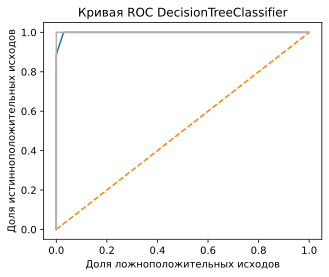

In [15]:
test_probabilities = DTC_S.predict_proba(features_upsampled)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(target_upsampled, test_probabilities)

plt.title('Кривая ROC DecisionTreeClassifier')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.7')
plt.plot([1, 1], c='.7')
plt.ylabel('Доля истинноположительных исходов')
plt.xlabel('Доля ложноположительных исходов')
plt.show()

Вывод: DecisionTreeClassifier выдает более высокие показатели относительно старой модели, в следствие чего можно сделать вывод о пользе балансировки и стратификации. Старый показатель: 52%, новый показатель: 87%.

In [16]:
#RFC = RandomForestClassifier(random_state=20)
#
#parametrs = { 'n_estimators': np.arange(1, 46),
#              'max_depth': np.arange(1, 21),
#              'min_samples_leaf': np.arange(1, 4),
#              'min_samples_split': np.arange(2, 4) }
#
#GSCV = GridSearchCV(RFC, parametrs, cv=5, n_jobs=-1, verbose=True, scoring='f1')
#GSCV.fit(features_upsampled, target_upsampled)
#
#GSCV.best_params_

---

In [23]:
RFC_S = RandomForestClassifier(random_state=20, max_depth=20, min_samples_leaf=1, min_samples_split=3, n_estimators=45)

RFC_S.fit(features_upsampled, target_upsampled)
valid_RFC_S = RFC_S.predict(features_valid)
test_RFC_S = RFC_S.predict(features_test)

print('F1 на валидационной выборке:', f'{f1_score(target_valid, valid_RFC_S):.2f}')
print('F1 на тестовой выборке:', f'{f1_score(target_test, test_RFC_S):.2f}')
print('AUC_ROC:', f'{roc_auc_score(target_test, RFC_S.predict_proba(features_test)[:,1]):.2f}')

F1 на валидационной выборке: 0.60
F1 на тестовой выборке: 0.62
AUC_ROC: 0.86


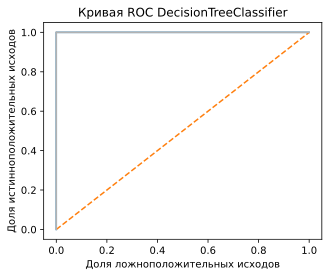

In [18]:
test_probabilities = RFC_S.predict_proba(features_upsampled)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(target_upsampled, test_probabilities)

plt.title('Кривая ROC DecisionTreeClassifier')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.7')
plt.plot([1, 1], c='.7')
plt.ylabel('Доля истинноположительных исходов')
plt.xlabel('Доля ложноположительных исходов')
plt.show()

Вывод: RandomForestClassifier выдает более высокие показатели относительно старой модели, в следствие чего можно сделать вывод о пользе балансировки и стратификации. Старый показатель: 57%, новый показатель: 93%.

---

## 4.1  Проверка на адеккватность

In [19]:
dummy = DummyClassifier(strategy='uniform', random_state=20)
dummy.fit(features_train, target_train)
dummy.score(features_valid, target_valid)
dummy.score(features_test, target_test)

0.49933333333333335

Вывод: Фиктивный классификатор с параметром 'uniform' дает случайные предсказания, которые состоят из равновероятных значений target. 50% - 0, 50% - 0. Данный способ показывает насколько случайные ответы далеки от ответов натренированной модели.

## 5  Итоговый вывод

Из эксперемента видно, что предобработка данных для машинного обучения помогает улучшить результативность. Существует много методов предобработки, но банальная балансировка и стратификация смогли довести результаты до 90+ процентов. Есть вероятность довести показатели и до 100 процентов, но для этого надо указать большую вариативность гиперпараметров, но ждать мне не хотелось. Мой результат в ожидании выявления лучших гиперпараметров методикой GridSearchCV составлял не менее 40 минут для каждой из построенных моделей.